# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [15]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [16]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [17]:
## load dataset here
df = pd.read_csv("icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [18]:
## parsing data here
images, labels = parse_data(df)


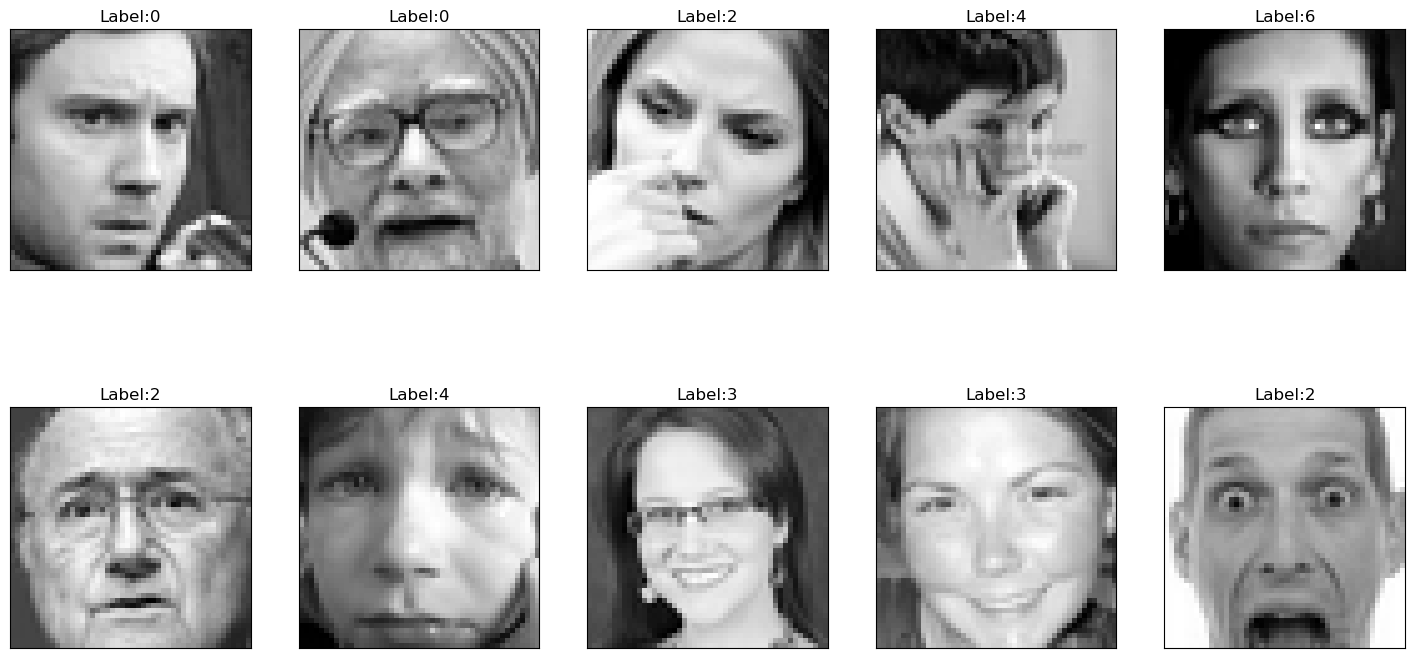

In [19]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [20]:
from sklearn.decomposition import PCA

# Reshape images for PCA
images_reshaped = images.reshape((images.shape[0], -1))

# Fit PCA
pca = PCA(n_components=2)
images_pca = pca.fit_transform(images_reshaped)

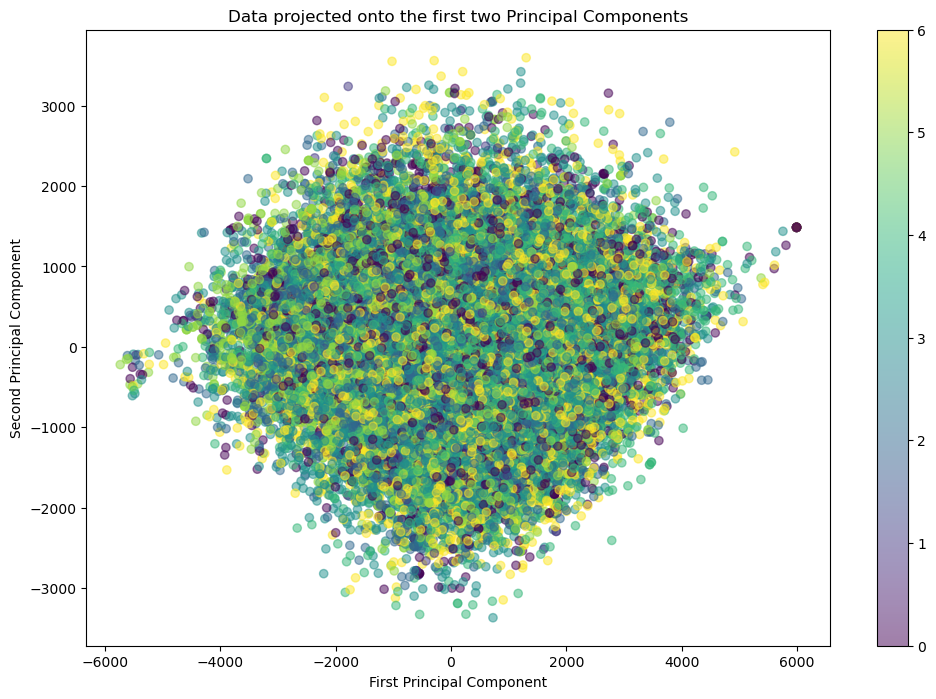

In [21]:
## transform for visualizing here
# images_pca=pca.transform(images) ## modify images' array to the appropriate shape
# images_pca.shape
plt.figure(figsize=(12, 8))
scatter = plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, ticks=range(7))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Data projected onto the first two Principal Components')
plt.show()

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

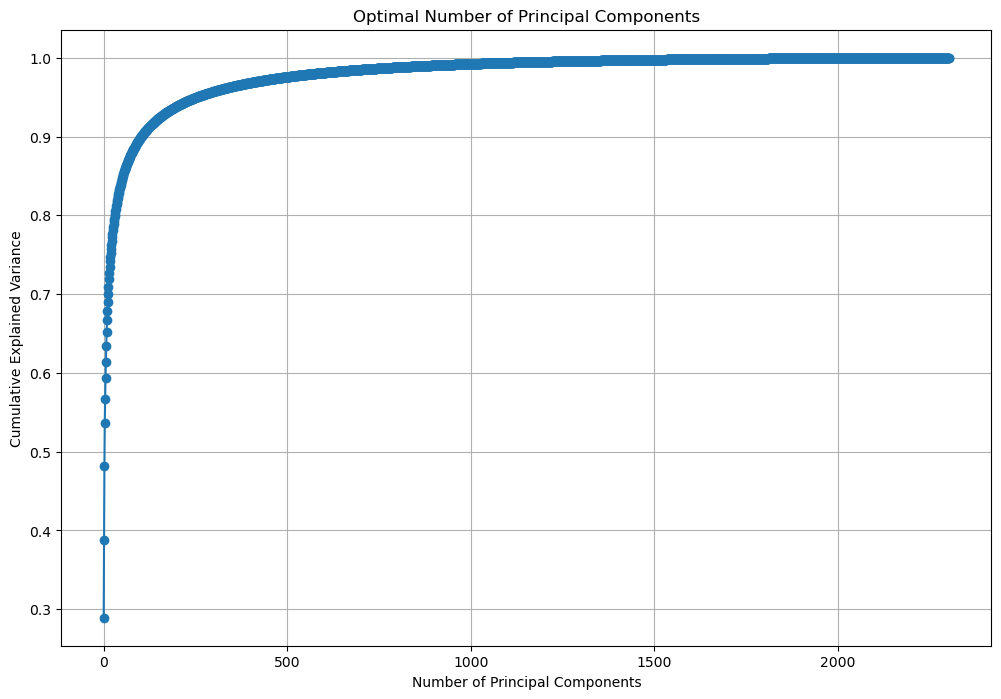

Optimal number of principal components: 255


In [22]:
## determine the optimal number of PCs here
## pca.explained_variance_()
# Fit PCA with all components
pca_full = PCA()
pca_full.fit(images_reshaped)

# Plot cumulative explained variance
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.figure(figsize=(12, 8))
plt.plot(explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Optimal Number of Principal Components')
plt.grid()
plt.show()

# Determine optimal number of components (e.g., 95% variance explained)
optimal_components = np.argmax(explained_variance >= 0.95) + 1
print(f'Optimal number of principal components: {optimal_components}')


## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

In [23]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(images_reshaped, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Apply PCA transformation with the optimal number of components
pca_optimal = PCA(n_components=optimal_components)
X_train_pca = pca_optimal.fit_transform(X_train)
X_val_pca = pca_optimal.transform(X_val)
X_test_pca = pca_optimal.transform(X_test)


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define models and parameter grids
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'DCT': DecisionTreeClassifier(),
    'MLP': MLPClassifier(max_iter=1000)
}

param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200]},
    'DCT': {'max_depth': [None, 5, 10]},
    'MLP': {'hidden_layer_sizes': [(100,), (100, 50)], 'alpha': [0.0001, 0.001]}
}

# Train and tune models using GridSearchCV
best_estimators = {}
for model_name in models:
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(models[model_name], param_grids[model_name], cv=3, scoring='accuracy')
    grid_search.fit(X_train_pca, y_train)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {model_name}: {grid_search.best_score_}")

# Example of fitting one model with original data for comparison
# (Repeat similar process for original data)
logistic_regression_orig = GridSearchCV(LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}, cv=3, scoring='accuracy')
logistic_regression_orig.fit(X_train, y_train)
best_logistic_regression_orig = logistic_regression_orig.best_estimator_
print(f"Best parameters for Logistic Regression (original data): {logistic_regression_orig.best_params_}")
print(f"Best cross-validation accuracy for Logistic Regression (original data): {logistic_regression_orig.best_score_}")
random_forest_orig = GridSearchCV(RandomForestClassifier(), {'n_estimators': [50, 100, 200]}, cv=3, scoring='accuracy')
random_forest_orig.fit(X_train, y_train)
best_random_forest_orig = random_forest_orig.best_estimator_
print(f"Best parameters for Random Forest (original data): {random_forest_orig.best_params_}")
print(f"Best cross-validation accuracy for Random Forest (original data): {random_forest_orig.best_score_}")
decision_tree_orig = GridSearchCV(DecisionTreeClassifier(), {'max_depth': [None, 5, 10]}, cv=3, scoring='accuracy')
decision_tree_orig.fit(X_train, y_train)
best_decision_tree_orig = decision_tree_orig.best_estimator_
print(f"Best parameters for Decision Tree (original data): {decision_tree_orig.best_params_}")
print(f"Best cross-validation accuracy for Decision Tree (original data): {decision_tree_orig.best_score_}")
mlp_orig = GridSearchCV(MLPClassifier(max_iter=1000), {'hidden_layer_sizes': [(100,), (100, 50)], 'alpha': [0.0001, 0.001]}, cv=3, scoring='accuracy')
mlp_orig.fit(X_train, y_train)
best_mlp_orig = mlp_orig.best_estimator_
print(f"Best parameters for MLP (original data): {mlp_orig.best_params_}")
print(f"Best cross-validation accuracy for MLP (original data): {mlp_orig.best_score_}")


Training Logistic Regression...


c:\Users\nhoch\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\nhoch\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best parameters for Logistic Regression: {'C': 1}
Best cross-validation accuracy for Logistic Regression: 0.3665241388847295
Training Random Forest...
Best parameters for Random Forest: {'n_estimators': 200}
Best cross-validation accuracy for Random Forest: 0.3681962760957947
Training DCT...
Best parameters for DCT: {'max_depth': 5}
Best cross-validation accuracy for DCT: 0.2869217101020011
Training MLP...
Best parameters for MLP: {'alpha': 0.001, 'hidden_layer_sizes': (100,)}
Best cross-validation accuracy for MLP: 0.3346648289126337


c:\Users\nhoch\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\nhoch\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best parameters for Logistic Regression (original data): {'C': 0.1}
Best cross-validation accuracy for Logistic Regression (original data): 0.31051458212894584


KeyboardInterrupt: 

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



Evaluating Logistic Regression with PCA-transformed data...
Accuracy: 0.37308442463081637
              precision    recall  f1-score   support

           0       0.26      0.16      0.20       940
           1       0.50      0.03      0.05       111
           2       0.25      0.14      0.18      1045
           3       0.45      0.66      0.53      1814
           4       0.28      0.30      0.29      1182
           5       0.49      0.46      0.48       836
           6       0.35      0.35      0.35      1250

    accuracy                           0.37      7178
   macro avg       0.37      0.30      0.30      7178
weighted avg       0.35      0.37      0.35      7178



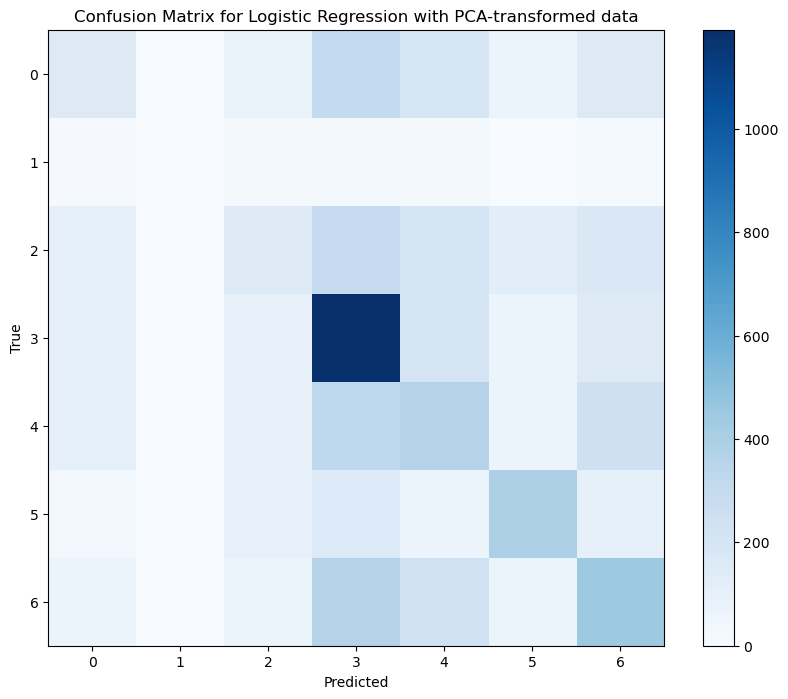

Evaluating Random Forest with PCA-transformed data...
Accuracy: 0.3987183059348008
              precision    recall  f1-score   support

           0       0.47      0.11      0.18       940
           1       1.00      0.20      0.33       111
           2       0.57      0.18      0.28      1045
           3       0.35      0.88      0.50      1814
           4       0.35      0.23      0.28      1182
           5       0.82      0.41      0.55       836
           6       0.41      0.26      0.32      1250

    accuracy                           0.40      7178
   macro avg       0.57      0.33      0.35      7178
weighted avg       0.47      0.40      0.36      7178



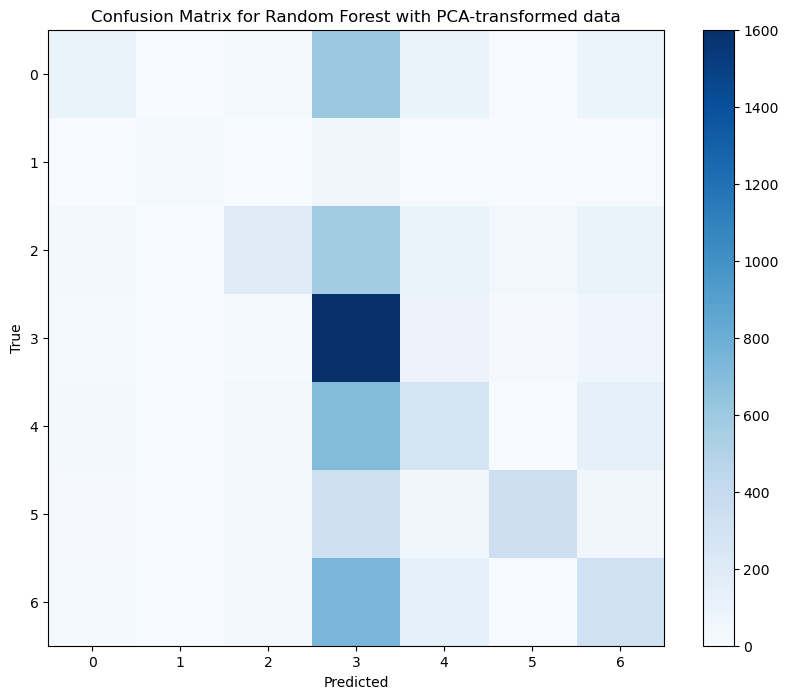

Evaluating DCT with PCA-transformed data...
Accuracy: 0.3052382279186403
              precision    recall  f1-score   support

           0       0.67      0.00      0.01       940
           1       0.00      0.00      0.00       111
           2       0.22      0.07      0.10      1045
           3       0.35      0.68      0.46      1814
           4       0.23      0.25      0.24      1182
           5       0.36      0.36      0.36       836
           6       0.24      0.24      0.24      1250

    accuracy                           0.31      7178
   macro avg       0.30      0.23      0.20      7178
weighted avg       0.33      0.31      0.26      7178



c:\Users\nhoch\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nhoch\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nhoch\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


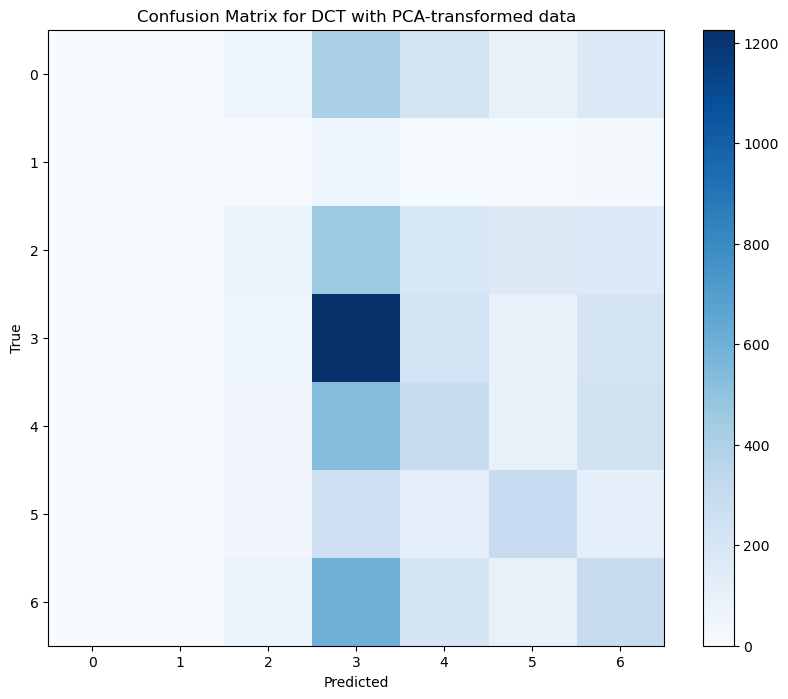

Evaluating MLP with PCA-transformed data...
Accuracy: 0.36110337141264975
              precision    recall  f1-score   support

           0       0.24      0.28      0.26       940
           1       0.25      0.25      0.25       111
           2       0.29      0.29      0.29      1045
           3       0.50      0.55      0.52      1814
           4       0.26      0.25      0.25      1182
           5       0.43      0.53      0.47       836
           6       0.37      0.22      0.27      1250

    accuracy                           0.36      7178
   macro avg       0.33      0.34      0.33      7178
weighted avg       0.36      0.36      0.36      7178



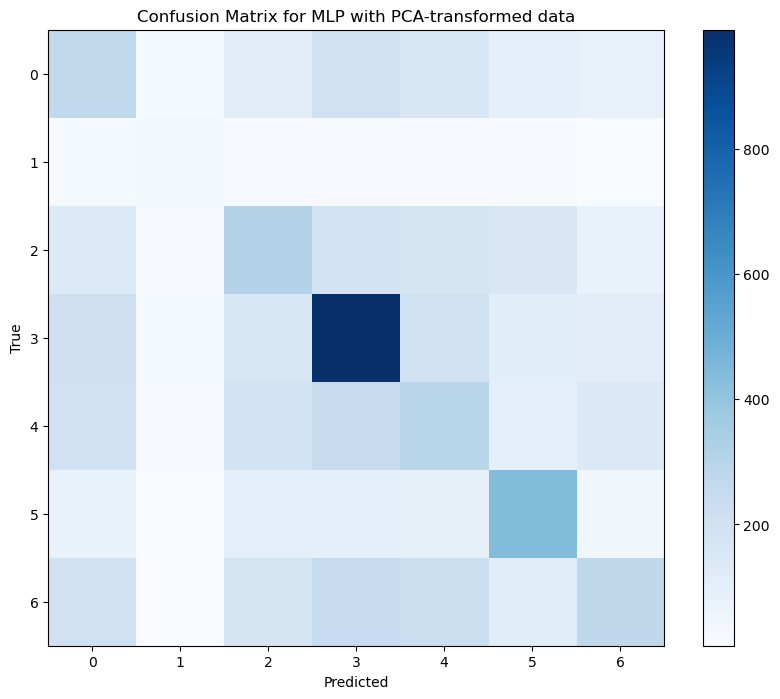

Evaluating Logistic Regression with original data...
Accuracy: 0.32836444692114797
              precision    recall  f1-score   support

           0       0.22      0.19      0.20       940
           1       0.31      0.13      0.18       111
           2       0.21      0.17      0.18      1045
           3       0.43      0.57      0.49      1814
           4       0.24      0.21      0.22      1182
           5       0.41      0.42      0.41       836
           6       0.30      0.29      0.30      1250

    accuracy                           0.33      7178
   macro avg       0.30      0.28      0.28      7178
weighted avg       0.31      0.33      0.32      7178



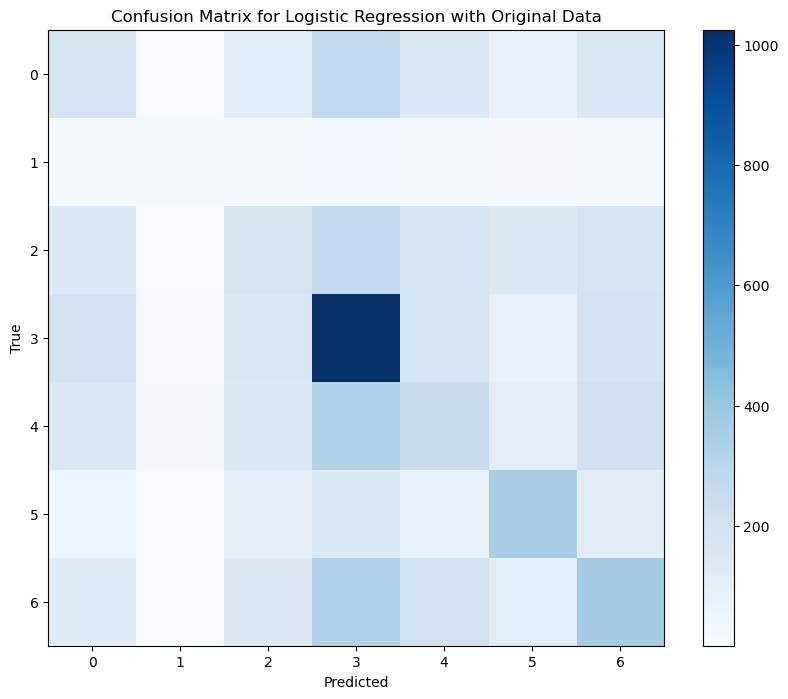

In [ ]:
## visualize the confusion matrices and classification reports here
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluate the models
for model_name in best_estimators:
    print(f"Evaluating {model_name} with PCA-transformed data...")
    y_pred = best_estimators[model_name].predict(X_test_pca)
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    plt.title(f'Confusion Matrix for {model_name} with PCA-transformed data')
    plt.imshow(cm, cmap='Blues')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluate Logistic Regression with original data
print(f"Evaluating Logistic Regression with original data...")
y_pred_orig = best_logistic_regression_orig.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_orig)}")
print(classification_report(y_test, y_pred_orig))
cm_orig = confusion_matrix(y_test, y_pred_orig)
plt.figure(figsize=(10, 8))
plt.title('Confusion Matrix for Logistic Regression with Original Data')
plt.imshow(cm_orig, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Evaluate Random forest with original data
print(f"Evaluating Random Forest with original data...")
y_pred_orig = best_random_forest_orig.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_orig)}")
print(classification_report(y_test, y_pred_orig))
cm_orig = confusion_matrix(y_test, y_pred_orig)
plt.figure(figsize=(10, 8))
plt.title('Confusion Matrix for Random Forest with Original Data')
plt.imshow(cm_orig, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluate Decision Tree with original data
print(f"Evaluating Decision Tree with original data...")
y_pred_orig = best_decision_tree_orig.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_orig)}")
print(classification_report(y_test, y_pred_orig))
cm_orig = confusion_matrix(y_test, y_pred_orig)
plt.figure(figsize=(10, 8))
plt.title('Confusion Matrix for Decision Tree with Original Data')
plt.imshow(cm_orig, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluate MLP with original data
print(f"Evaluating MLP with original data...")
y_pred_orig = best_mlp_orig.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_orig)}")
print(classification_report(y_test, y_pred_orig))
cm_orig = confusion_matrix(y_test, y_pred_orig)
plt.figure(figsize=(10, 8))
plt.title('Confusion Matrix for MLP with Original Data')
plt.imshow(cm_orig, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Conclusion
Best Model: The Random Forest with PCA-transformed data performs the best overall, with the highest accuracy (0.3987) and reasonable precision, recall, and F1-scores.

Emotion Category Performance:

Most Accurate: The "Happy" emotion category (label 3) is where most models, including Random Forest, achieve the highest recall and F1-scores.
Most Errors: The "Disgust" emotion category (label 1) is where most models perform the worst, with very low precision, recall, and F1-scores.
This analysis shows that the Random Forest model with PCA-transformed data achieves the best overall performance, likely due to its ability to handle complex patterns in the reduced dimensional space. The challenging "Disgust" category highlights the need for more refined features or additional data to improve classification in this area.